<a href="https://www.mayoclinic.org/"><img src="images/mayologo.png" alt="Mayo Logo"></a>
# Medical Image Classification Using the MedNIST Dataset
### Special thanks to <a href="https://www.mayo.edu/research/labs/radiology-informatics/overview">Dr. Bradley J. Erickson M.D., Ph.D.</a> - Department of Radiology, Mayo Clinic
#### Acknowledgements: <a href="http://www.cancerimagingarchive.net/">The Cancer Imaging Archive (TCIA)</a>; <a href ="http://rsnachallenges.cloudapp.net/competitions/4">Radiological Society of North America</a>; <a href= "http://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf">National Institute of Health</a>


## Deep Learning and Frameworks

### Code Block 1


In [1]:
import torch
print(torch.__version__)

1.10.0


In [1]:
import numpy as np
import os
import time
%matplotlib inline
import matplotlib.pyplot as mp
from PIL import Image

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as om
import torchvision as tv
import torch.utils.data as dat

if torch.cuda.is_available():     # Make sure GPU is available
    dev = torch.device("cuda:0")
    kwar = {'num_workers': 8, 'pin_memory': True}
    cpu = torch.device("cpu")
else:
    print("Warning: CUDA not found, CPU only.")
    dev = torch.device("cpu")
    kwar = {}
    cpu = torch.device("cpu")

np.random.seed(551)

## Loading Data and Creating Datasets

The code below examines our image set, organizes the filenames, and displays some statistics about them.

### Code Block 2

In [3]:
dataDir = 'resized'               # The main data directory
classNames = os.listdir(dataDir)  # Each type of image can be found in its own subdirectory
numClass = len(classNames)        # Number of types = number of subdirectories
imageFiles = [[os.path.join(dataDir,classNames[i],x) for x in os.listdir(os.path.join(dataDir,classNames[i]))]
              for i in range(numClass)]                     # A nested list of filenames
#imageFiles[5] = imageFiles[5][:-NNN] # To unbalanced data classes
numEach = [len(imageFiles[i]) for i in range(numClass)]     # A count of each type of image
imageFilesList = []               # Created an un-nested list of filenames
imageClass = []                   # The labels -- the type of each individual image in the list
for i in range(numClass):
    imageFilesList.extend(imageFiles[i]) # Liste regroupant tous les (noms de) fichiers
    imageClass.extend([i]*numEach[i]) # Liste définissant la classe de chaque fichier
numTotal = len(imageClass)        # Total number of images
imageWidth, imageHeight = Image.open(imageFilesList[0]).size         # The dimensions of each image

print("There are",numTotal,"images in",numClass,"distinct categories")
print("Label names:",classNames)
print("Label counts:",numEach)
print("Image dimensions:",imageWidth,"x",imageHeight)


FileNotFoundError: [Errno 2] No such file or directory: 'resized'

### Code Block 3

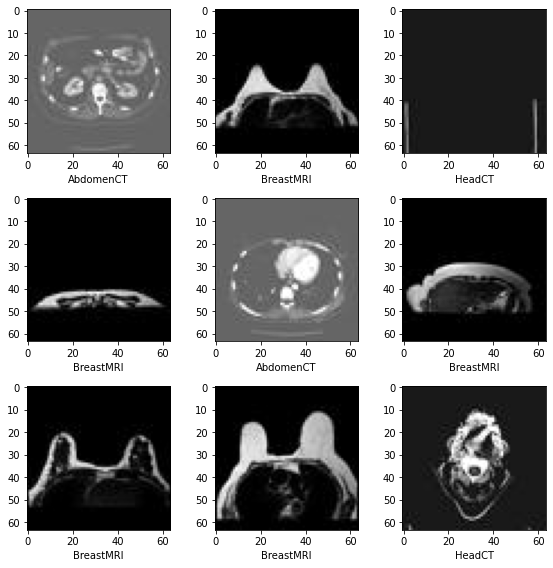

In [4]:
mp.subplots(3,3,figsize=(8,8))
for i,k in enumerate(np.random.randint(numTotal, size=9)):  # Take a random sample of 9 images (indices) and
    im = Image.open(imageFilesList[k])                      #      plot and label them
    arr = np.array(im)
    mp.subplot(3,3,i+1)
    mp.xlabel(classNames[imageClass[k]]) # Label réel de l'image
    mp.imshow(arr,cmap='gray',vmin=0,vmax=255)
mp.tight_layout()
mp.show()


## Transforming Data and Partitioning into Training, Validation, and Testing Sets

Because there's a smaller difference between pixels, our model might have a harder time extracting information from them. Thus, to increase the contrast, we first rescale every image so the pixel values run from 0 to 1. 

Next, we subtract the mean pixel value of each individual image from the rest. The network could in principle learn to do this through training. However, the activation functions tend to be most sensitive / nonlinear near zero. Therefore, shifting our data to have an average input value of zero will improve the sensitivity and stability of initial training steps and tends to speed things up a little.

Also, before doing any of these, we'll need to convert the JPEG images into tensors. We define a function below that combines all these steps.

### Code Block 4

In [5]:
toTensor = tv.transforms.ToTensor()
def scaleImage(x):          # Pass a PIL image, return a tensor
    y = toTensor(x)
    if(y.min() < y.max()):  # Assuming the image isn't empty, rescale so its values run from 0 to 1
        y = (y - y.min())/(y.max() - y.min()) 
    z = y - y.mean()        # Subtract the mean value of the image
    return z


With the image-to-tensor transformation function defined, we now create a master tensor out of all these images. We also create a tensor for the labels. Execution of this code takes a moment. We double check the final range of scaled pixel values and verify that the mean is (practically) zero.

### Code Block 5

In [6]:
imageTensor = torch.stack([scaleImage(Image.open(x)) for x in imageFilesList]) #Load, scale and stack image(X) tensor
classTensor = torch.tensor(imageClass)  # Create label (Y) tensor
print("Rescaled min pixel value = {:1.3}; Max = {:1.3}; Mean = {:1.3}"
      .format(imageTensor.min().item(),imageTensor.max().item(),imageTensor.mean().item()))

Rescaled min pixel value = -0.786; Max = 0.972; Mean = -2.59e-09



### Code Block 6

In [7]:
validFrac = 0.1   # Define the fraction of images to move to validation dataset
testFrac = 0.1    # Define the fraction of images to move to test dataset
validList = []
testList = []
trainList = []

for i in range(numTotal):
    rann = np.random.random() # Randomly reassign images
    if rann < validFrac:
        validList.append(i)
    elif rann < testFrac + validFrac:
        testList.append(i)
    else:
        trainList.append(i)
        
nTrain = len(trainList)  # Count the number in each set
nValid = len(validList)
nTest = len(testList)
print("Training images =",nTrain,"Validation =",nValid,"Testing =",nTest)

Training images = 47381 Validation = 5833 Testing = 5740



### Code Block 7

In [8]:
trainIds = torch.tensor(trainList)    # Slice the big image and label tensors up into
validIds = torch.tensor(validList)    #       training, validation, and testing tensors
testIds = torch.tensor(testList)
trainX = imageTensor[trainIds,:,:,:]
trainY = classTensor[trainIds]
validX = imageTensor[validIds,:,:,:]
validY = classTensor[validIds]
testX = imageTensor[testIds,:,:,:]
testY = classTensor[testIds]

## Model Architecture


Now, there is one additional step in each of these that has been omitted: appication of the activation function. If the linear function `y = 3x + 2` is composed with `z = 4y - 7`, then z is still a linear function of x: `z = 12x + 1`. The same thing is true for linear functions in higher dimensions (multiplication by weights and summing, as we have been doing). Without the activation function, no matter how many layers we stack together, it could ultimately be replaced by a single one. To avoid this, at each output layer, we apply a nonlinear activation function. This need not be the same function at every layer.

### Code Block 8

In [69]:
class MedNet(nn.Module):
    def __init__(self,xDim,yDim,numC):
        super(MedNet,self).__init__()
        
        numConvs1 = 33
        convSize1 = 3
        #numConvs11 = 15
        #convSize11 = 3
        numConvs2 = 20
        convSize2 = 5
        numConvs3 = 20
        convSize3 = 5
        numConvs4 = 10
        convSize4 = 5

        #numNodesToFC = numConvs2*(xDim-(convSize1-1)-(convSize2-1))*(yDim-(convSize1-1)-(convSize2-1))
        #numNodesToFC = numConvs2*(xDim*yDim)
        numNodesToFC = numConvs2*((xDim-1)*(yDim-1))
        
        self.cnv1 = nn.Conv2d(1, numConvs1, convSize1, padding='same')          #bias=False
        #self.cnv11 = nn.Conv2d(numConvs1, numConvs11, convSize11, padding='same')          #bias=False
        self.cnv2 = nn.Conv2d(numConvs1, numConvs2, convSize2, padding='same')
        self.maxp = nn.MaxPool2d(kernel_size=2, stride=1)                       #padding=1, dilation=1, ceil_mode=False
        #self.cnv_drop = nn.Dropout2d(p=0.2)  # training=True, inplace=False
        #self.cnv3 = nn.Conv2d(numConvs2, numConvs3, convSize3, padding='same')
        #self.cnv4 = nn.Conv2d(numConvs3, convSize4, convSize4, padding='same')
        #self.bn1 = BatchNorm2d(numConvs1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        #self.relu = ReLU(inplace=True)
        
        fcSize1 = 200
        fcSize2 = 400
        fcSize3 = 60
        
        self.ful1 = nn.Linear(numNodesToFC,fcSize1)
        self.ful2 = nn.Linear(fcSize1, fcSize2)
        self.ful3 = nn.Linear(fcSize2, fcSize3)
        self.ful4 = nn.Linear(fcSize3,numC)

        
    def forward(self,x):
        
        x = self.cnv1(x)
        #x = self.cnv11(x)
        x = self.cnv2(x)
        #x = self.conv_drop(x)
        x = F.batch_norm(x, running_mean=None, running_var=None, training=True, momentum=0.2, eps=1e-06)
        x = F.leaky_relu(x, negative_slope=0.05, inplace=True)
        x = self.maxp(x)
        #x = F.selu(self.maxp(x)) # F.selu(F.max_pool2d(x, 2))
        #x = F.selu(F.max_pool2d(self.conv_drop(self.conv2(x)), 2))

        x = x.view(-1,self.num_flat_features(x))
        x = self.ful1(x)
        #x = self.conv_drop(x)  # F.dropout(x, training=self.training)
        x = F.batch_norm(x, running_mean=None, running_var=None, training=True, momentum=0.25, eps=1e-06) # bias=None, training=False
        x = F.leaky_relu(x, negative_slope=0.05, inplace=True)
        #x = F.selu(x)
        x = self.ful2(x)
        #x = self.conv_drop(x)
        x = F.batch_norm(x, running_mean=None, running_var=None, training=True, momentum=0.25, eps=1e-06)
        x = F.leaky_relu(self.ful3(x), negative_slope=0.05, inplace=True)
        #x = self.conv_drop(x)
        x = F.selu(self.ful4(x))
        #x = F.softmax(x)
        return x


    def num_flat_features(self, x):  # Count individual nodes in a layer
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

With the architecture defined, we create an instance of the model.

### Code Block 9

In [70]:
model = MedNet(imageWidth,imageHeight,numClass).to(dev)

In [12]:
for x in model.named_modules():
  print(x[0], x[1], "\n-------------------------------")

 MedNet(
  (cnv1): Conv2d(1, 30, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (cnv2): Conv2d(30, 20, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (maxp): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (ful1): Linear(in_features=79380, out_features=200, bias=True)
  (ful2): Linear(in_features=200, out_features=400, bias=True)
  (ful3): Linear(in_features=400, out_features=60, bias=True)
  (ful4): Linear(in_features=60, out_features=6, bias=True)
) 
-------------------------------
cnv1 Conv2d(1, 30, kernel_size=(3, 3), stride=(1, 1), padding=same) 
-------------------------------
cnv2 Conv2d(30, 20, kernel_size=(5, 5), stride=(1, 1), padding=same) 
-------------------------------
maxp MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False) 
-------------------------------
ful1 Linear(in_features=79380, out_features=200, bias=True) 
-------------------------------
ful2 Linear(in_features=200, out_features=400, bias=True) 
------

In [19]:
# Total number of parameters
total_params = [sum(p.numel() for p in model.parameters()), 
                sum(p.numel() for p in model.parameters() if p.requires_grad),
                torch.nn.utils.parameters_to_vector(model.parameters()).numel()]
total_params

[15990736, 15990736, 15990736]

In [28]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

+-------------+------------+
|   Modules   | Parameters |
+-------------+------------+
| cnv1.weight |    297     |
|  cnv1.bias  |     33     |
| cnv2.weight |   16500    |
|  cnv2.bias  |     20     |
| ful1.weight |  15876000  |
|  ful1.bias  |    200     |
| ful2.weight |   80000    |
|  ful2.bias  |    400     |
| ful3.weight |   24000    |
|  ful3.bias  |     60     |
| ful4.weight |    360     |
|  ful4.bias  |     6      |
+-------------+------------+
Total Trainable Params: 15997876


15997876

## Training the Model

Now, it's time to train the model. The next code block does so.

First, we define the hyperparameters of the training. The learning rate reflects how much the model is updated per batch. If it is too small, the training proceeds slowly. If it's too large, the weights will be adjusted too much and miss the true minimum loss, or even become unstable. An epoch is a full run through the training data. Some models require thousands of epochs to train; this one will produce high accuracy with just a handful.

We use validation data to prevent overtraining in our model. The training and validation data are drawn from the same set of data; therefore, the model ought to have similar loss for both. Thus, we set a limit on how much larger the validation loss can be than the training loss. Because random fluctuation might account for some discrepancy, we require a few epochs pass with high validation loss before halting.

The memory overhead required to feed large datasets through the model can be prohibitive. <em>Batches</em> are an important workaround for this problem. By loading smaller data subsets onto the GPU and training off of them, we can not only save memory, but also speed up the training by making more adjustments to the model per epoch. Smaller batches generally require smaller learning rates to avoid instability, however, so there is some tradeoff.

Imagine that a dataset had only a handful of examples of a particular label. The model could still acheive high accuracy overall while totally ignoring these. Using weights in the loss function, with larger weights for less numerous classes, is one strategy to combat this. If a class is particularly tiny, however, it is preferable to use data augmentation to generate new images rather than using weights alone, which are equivalent to feeding the same image over and over again through the network.

Now, we move on to the actual training loop. The first real step is to shuffle the data before slicing it into batches. Once again, PyTorch provides a <a href="https://pytorch.org/docs/stable/_modules/torch/utils/data/dataloader.html#DataLoader">DataLoader</a> class that can automate this, but it's about the same difficulty in this example to implement by hand.

Next, we iterate through the batches. We zero out the accumulated information in the optimizer, feed the batch through the model, and compute the loss for a batch. We use the <a href="https://en.wikipedia.org/wiki/Cross_entropy">cross entropy</a>, a common metric for classifiers. This loss is added to a running total for the epoch, and then we <em>backpropagate</em> it. Backpropagation is a mathematical determination of how much each weight in the model should be changed relative to the others to reduce the loss. The optimizer then takes a step and updates the weights.

After all the training batches are complete, the same process happens for the validation data, without the backpropagation and optimization steps. The average loss is calculated, and we compare the validation loss relative to the training loss to test for overfitting.

Run the cell to train the model.

### Code Block 10

In [71]:
learnRate = 0.023
maxEpochs = 20
t2vRatio = 1.25
t2vEpochs = 3
batchSize = 333
trainBats = nTrain // batchSize
validBats = nValid // batchSize
testBats = -(-nTest // batchSize)
CEweights = torch.zeros(numClass)     # This takes into account the imbalanced dataset.
for i in trainY.tolist():             # By making rarer images count more to the loss, 
    CEweights[i].add_(1)              # we prevent the model from ignoring them.
CEweights = 1. / CEweights.clamp_(min=1.)                     # Weights should be inversely related to count
CEweights = (CEweights * numClass / CEweights.sum()).to(dev)  # The weights average to 1
opti = om.SGD(model.parameters(), lr = learnRate, momentum=0.5)   # nesterov=True
#opti = om.Adamax(model.parameters(), lr = learnRate, betas=(0.9, 0.999), eps=1e-06, weight_decay=0)
#scheduler = om.lr_scheduler.StepLR(opti, step_size=2, gamma=0.07, last_epoch=-1, verbose=False)
#scheduler = om.lr_scheduler.ExponentialLR(opti, gamma=0.07, last_epoch=-1, verbose=False)


for i in range(maxEpochs):
    model.train()                     # Set model to training mode
    epochLoss = 0.
    permute = torch.randperm(nTrain)  # Shuffle data to randomize batches
    trainX = trainX[permute,:,:,:]
    trainY = trainY[permute]
    for j in range(trainBats):        # Iterate over batches
        opti.zero_grad()              # Zero out gradient accumulated in optimizer
        batX = trainX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)   # Slice shuffled data into batches
        batY = trainY[j*batchSize:(j+1)*batchSize].to(dev)
        yOut = model(batX)
        loss = F.cross_entropy(yOut, batY,weight=CEweights)        # Compute loss
        epochLoss += loss.item()      # Add loss
        loss.backward()               # Backpropagate loss
        opti.step()                   # Update model weights using optimizer
    validLoss = 0.
    permute = torch.randperm(nValid)  # We go through the exact same steps, without backprop / optimization
    validX = validX[permute,:,:,:]    # in order to evaluate the validation loss
    validY = validY[permute]
    model.eval()
    with torch.no_grad():             # Temporarily turn off gradient descent
        for j in range(validBats):
            opti.zero_grad()
            batX = validX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
            batY = validY[j*batchSize:(j+1)*batchSize].to(dev)
            yOut = model(batX)
            validLoss += F.cross_entropy(yOut, batY,weight=CEweights).item()
    epochLoss /= trainBats            # Average loss over batches and print
    validLoss /= validBats
    print("Epoch = {:-3}; Training loss = {:.4f}; Validation loss = {:.4f}".format(i,epochLoss,validLoss))
    if validLoss > t2vRatio * epochLoss:
        t2vEpochs -= 1                # Test if validation loss exceeds halting threshold
        if t2vEpochs < 1:
            print("Validation loss too high; halting to prevent overfitting")
            break

Epoch =   0; Training loss = 0.0948; Validation loss = 0.0093
Epoch =   1; Training loss = 0.0071; Validation loss = 0.0056
Epoch =   2; Training loss = 0.0030; Validation loss = 0.0035
Epoch =   3; Training loss = 0.0017; Validation loss = 0.0030
Epoch =   4; Training loss = 0.0011; Validation loss = 0.0025
Epoch =   5; Training loss = 0.0008; Validation loss = 0.0020
Validation loss too high; halting to prevent overfitting


It is most likely that training was halted early to prevent overfitting. Still, the final loss should be roughly 0.01, a huge improvement on the random guessing that the model begins with. (These are slightly dependent on how the random numbers pan out based on how many times earlier cells were executed)

You may have also noticed that the training loss is quite a bit larger than the validation loss for the first several training steps. <b>Based on what you've learned about the training process, can you explain why this happens?</b>

## Testing the Model on New Data

With the model fully trained, it's time to apply it to generate predictions from the test dataset. The model outputs a 6 element vector for each image. The individual values of this vector can be thought of, roughly, as relative probabilities that the image belongs in each class. Thus, we consider the class with the maximum value to be the prediction of the model.

We'll use these predictions to generate a confusion matrix. Despite its name, the confusion matrix is easily understood. The rows in the matrix represent the correct classifications, while the columns represent the predictions of the model. When the row and the column agree (i.e., along the diagonal), the model predicted correctly.

The short code snippet below iterates through the test batches and fills the confusion matrix.

### Code Block 11

In [72]:
confuseMtx = np.zeros((numClass,numClass),dtype=int)    # Create empty confusion matrix
model.eval()
with torch.no_grad():
    permute = torch.randperm(nTest)                     # Shuffle test data
    testX = testX[permute,:,:,:]
    testY = testY[permute]
    for j in range(testBats):                           # Iterate over test batches
        batX = testX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
        batY = testY[j*batchSize:(j+1)*batchSize].to(dev)
        yOut = model(batX)                              # Pass test batch through model
        pred = yOut.max(1,keepdim=True)[1]              # Generate predictions by finding the max Y values
        for j in torch.cat((batY.view_as(pred), pred),dim=1).tolist(): # Glue together Actual and Predicted to
            confuseMtx[j[0],j[1]] += 1                  # make (row, col) pairs, and increment confusion matrix
correct = sum([confuseMtx[i,i] for i in range(numClass)])  # Sum diagonal elements to count correct predictions
print("Correct predictions: ",correct,"of",nTest)
print("Confusion Matrix:")
print(confuseMtx)
print(classNames)

Correct predictions:  5735 of 5740
Confusion Matrix:
[[ 971    0    0    1    0    0]
 [   0 1003    0    0    0    0]
 [   0    0  985    0    0    0]
 [   3    0    1  955    0    0]
 [   0    0    0    0  951    0]
 [   0    0    0    0    0  870]]
['CXR', 'AbdomenCT', 'HeadCT', 'Hand', 'ChestCT', 'BreastMRI']


In [ ]:
precision_score, recall_score, f1_score, accuracy_score
calculate_metric(metric, batY.cpu(), pred.cpu())

You're likely to see 99%+ accuracy. Not bad for a fairly minimal model that trains in just a couple minutes. Now look at the confusion matrix. Notice that some mistakes are more common than others - <b>does this type of confusion make sense to you?</b>

Before we get to the exercises, let's take a look at some of the images that confused the model. This cell can be rerun to produce more examples.

### Code Block 12


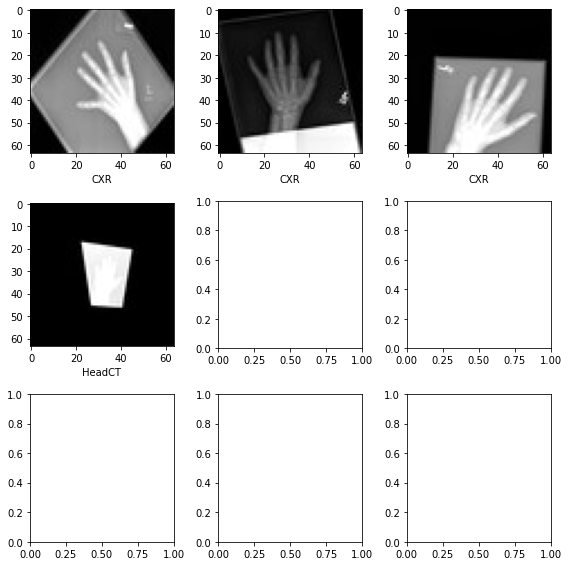

In [63]:
def scaleBack(x):               # Pass a tensor, return a numpy array from 0 to 1
    if(x.min() < x.max()):      # Assuming the image isn't empty, rescale so its values run from 0 to 1
        x = (x - x.min())/(x.max() - x.min())
    return x[0].to(cpu).numpy() # Remove channel (grayscale anyway)

model.eval()
mp.subplots(3,3,figsize=(8,8))
imagesLeft = 9
permute = torch.randperm(nTest)        # Shuffle test data
testX = testX[permute,:,:,:]
testY = testY[permute]
for j in range(testBats):              # Iterate over test batches
    batX = testX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
    batY = testY[j*batchSize:(j+1)*batchSize].to(dev)
    yOut = model(batX)                 # Pass test batch through model
    pred = yOut.max(1)[1].tolist()     # Generate predictions by finding the max Y values
    for i, y in enumerate(batY.tolist()):
        if imagesLeft and y != pred[i]:         # Compare the actual y value to the prediction
            imagesLeft -= 1
            mp.subplot(3,3,9-imagesLeft)
            mp.xlabel(classNames[pred[i]])      # Label image with what the model thinks it is
            mp.imshow(scaleBack(batX[i]),cmap='gray',vmin=0,vmax=1)
mp.tight_layout()
mp.show()

In [129]:
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

ModuleNotFoundError: No module named 'tensorboard'

In [99]:
pwd

'E:\\BootCamp\\Brief11\\Medical-MNIST-Classification-master'

In [100]:
ls

 Le volume dans le lecteur E s'appelle Nouveau nom
 Le num‚ro de s‚rie du volume est 26BC-CD68

 R‚pertoire de E:\BootCamp\Brief11\Medical-MNIST-Classification-master

26/11/2021  09:40    <DIR>          .
26/11/2021  09:40    <DIR>          ..
22/11/2021  14:02    <DIR>          .ipynb_checkpoints
24/11/2021  21:55           472ÿ037 classTensor.pkl
22/11/2021  14:00             2ÿ289 hints.txt
27/02/2019  10:48    <DIR>          images
24/11/2021  21:55       965ÿ902ÿ760 imageTensor.pkl
24/11/2021  22:45       965ÿ903ÿ083 imageTensor.pt
26/11/2021  09:40           376ÿ805 MedNIST.ipynb
25/11/2021  14:42        43ÿ409ÿ543 new_model
25/11/2021  14:20        43ÿ409ÿ543 new_model.pkl
24/11/2021  02:16    <DIR>          resized
24/11/2021  02:58        43ÿ410ÿ759 saved_model
25/11/2021  15:09        94ÿ044ÿ584 testX.pkl
25/11/2021  15:09            46ÿ316 testY.pkl
25/11/2021  14:10        43ÿ411ÿ019 torch_model.pkl
              11 fichier(s)    2ÿ200ÿ388ÿ738 octets
               5 R‚p(s

In [17]:
torch.save(model, 'best_model.pt')

In [ ]:
tensor_dict = torch.load('model_optim.dat', map_location='cpu') # Ordered Dict
tensor_list = list(tensor_dict.items())
for layer_tensor_name, tensor in tensor_list:
    print('Layer {}: {} elements'.format(layer_tensor_name, torch.numel(tensor)))

Some of these images are indeed confusing, even for a human observer. Yet other other ones are harder to fathom - why did a model with 99% accuracy misclassify what is so obviously a hand, for example? The field of <a href="https://medium.com/@jrzech/what-are-radiological-deep-learning-models-actually-learning-f97a546c5b98">interpretability is beginning to explore these questions</a>.

## Exercises

It may be useful to restart the kernel (under Kernel menu) to clear the memory between exercises, or even to copy the notebook (under File menu) and do each exercise in a clean copy. Because time may be limited, scan through the exercises and start with the ones that most appeal to you. Exercises 1, 2, and 3 are particularly recommended if you are new to deep learning.

<ol>
    <li>Without resetting the kernel, increase <code>t2vRatio</code> in code block 10 and continue the training. Can you improve the final accuracy observed on the test dataset this way? If so, does it improve as much as the change in training loss would seem to indicate? What might this suggest about the relative value of architecting to training?</li><hr>
        <li>Reset the model by running code block 9, then modify the hyperparameters and retraing the model in code block 10. The most interesting ones are the learning rate (larger or smaller) and the batch size (smaller works well; when increasing the batch size, you will run out of memory somewhere in the low thousands). Note the effects on training. Can you make it converge faster than the default values?</li><hr>
    <li>Modify the architecture in code block 8 and note the effects on the training speed and final accuracy
        <ol>
            <li> Easy: Change the number of convolutions, the size of the convolutions, and the number of fully connected layers</li>
            <li> Medium: Add additional convolutional and/or fully connected layers. Use the existing code for reference.</li>
            <li> Hard: Add <a href="https://pytorch.org/docs/stable/_modules/torch/nn/modules/batchnorm.html#BatchNorm1d">batchnorm</a>, <a href="https://pytorch.org/docs/stable/_modules/torch/nn/modules/pooling.html#MaxPool2d">maxpool</a>, and/or <a href="https://pytorch.org/docs/stable/_modules/torch/nn/modules/dropout#Dropout">dropout</a> layers.</li>
        </ol>
    </li><hr>
    <li>Unbalance the classes. This is a common problem in medical imaging, and can be done by adding a single line of code in code block 2: <code>imageFiles[5] = imageFiles[5][:-NNN]</code> where <code>NNN</code> is the number images from the final class to remove. You could also replace the 5 with 0 - 4, instead. Insert this line between <code>imageFiles = ...</code> and <code>numEach = ...</code> How small of a set can you have while still getting good results for this class in the confusion matrix? This exercise combines well with the next one.</li><hr>
    <li>Remove the weights for the loss function by adding <code>CEweights = torch.ones(numClass).to(dev)</code> after the line <code>opti = ...</code> in code block 10. What effect does this have in the confusion matrix when identifying the rarer image class? You could also implement custom weights by using <code>CEweights = torch.tensor([a,b,c,d,e,f]).to(dev)</code> where <code>a ... f</code> are floating point numbers. In this case, note the effects of having one or more relatively large weights.</li><hr>
    <li>Remove one or both of the modifications to the tensor from code block 4. Note the effects on the early training and final accuracy.</li><hr>
    <li><b>Final challenge:</b>By using experience gained from the previous exercises, you can adjust the architecture and training to make a more accurate final model. Can your improved model make fewer than 10 mistakes on the testing set?</li>
</ol>



<a href="hints.txt">Hints and partial solutions to the exercises</a>